# Lab | Data Aggregation and Filtering

In this challenge, we will continue to work with customer data from an insurance company. We will use the dataset called marketing_customer_analysis.csv, which can be found at the following link:

https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv

This dataset contains information such as customer demographics, policy details, vehicle information, and the customer's response to the last marketing campaign. Our goal is to explore and analyze this data by first performing data cleaning, formatting, and structuring.

1. Create a new DataFrame that only includes customers who have a total_claim_amount greater than $1,000 and have a response of "Yes" to the last marketing campaign.

2. Using the original Dataframe, analyze the average total_claim_amount by each policy type and gender for customers who have responded "Yes" to the last marketing campaign. Write your conclusions.

3. Analyze the total number of customers who have policies in each state, and then filter the results to only include states where there are more than 500 customers.

4. Find the maximum, minimum, and median customer lifetime value by education level and gender. Write your conclusions.

In [171]:
import pandas as pd

url = 'https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv'

df = pd.read_csv(url)

#work on column
df.columns = [column.lower().replace(' ','_') for column in df.columns]
df = df.drop(columns=['unnamed:_0'])

#work on val
df['response'] = df['response'].fillna('No')


print(df.dtypes)

#1.
condition1 = df['total_claim_amount'] > 1000
condition2 = df['response'] == 'Yes'

df1 = df[condition1 & condition2]

#2.

df2 = df[condition2]
grouped = df2.groupby(['policy_type','gender'])['total_claim_amount'].mean()

#3.

condition3 = df['state'].notnull() #pas de null vall dans state
df3 = df[condition3]
grouped_df3 = df3.groupby(['state'])['number_of_policies'].sum()

#4.
grouped4 = df.groupby(['education','gender'])['customer_lifetime_value'].agg({'max','min','median'})
grouped4 = round(grouped4,2)

print(grouped4)
print()
print()
display(df3)


customer                          object
state                             object
customer_lifetime_value          float64
response                          object
coverage                          object
education                         object
effective_to_date                 object
employmentstatus                  object
gender                            object
income                             int64
location_code                     object
marital_status                    object
monthly_premium_auto               int64
months_since_last_claim          float64
months_since_policy_inception      int64
number_of_open_complaints        float64
number_of_policies                 int64
policy_type                       object
policy                            object
renew_offer_type                  object
sales_channel                     object
total_claim_amount               float64
vehicle_class                     object
vehicle_size                      object
vehicle_type    

,customer,state,customer_lifetime_value,response,coverage,education,effective_to_date,employmentstatus,gender,income,...,number_of_open_complaints,number_of_policies,policy_type,policy,renew_offer_type,sales_channel,total_claim_amount,vehicle_class,vehicle_size,vehicle_type
0,DK49336,Arizona,4809.216960,No,Basic,College,2/18/11,Employed,M,48029,...,0.0,9,Corporate Auto,Corporate L3,Offer3,Agent,292.800000,Four-Door Car,Medsize,NaN
1,KX64629,California,2228.525238,No,Basic,College,1/18/11,Unemployed,F,0,...,0.0,1,Personal Auto,Personal L3,Offer4,Call Center,744.924331,Four-Door Car,Medsize,NaN
2,LZ68649,Washington,14947.917300,No,Basic,Bachelor,2/10/11,Employed,M,22139,...,0.0,2,Personal Auto,Personal L3,Offer3,Call Center,480.000000,SUV,Medsize,A
3,XL78013,Oregon,22332.439460,Yes,Extended,College,1/11/11,Employed,M,49078,...,0.0,2,Corporate Auto,Corporate L3,Offer2,Branch,484.013411,Four-Door Car,Medsize,A
4,QA50777,Oregon,9025.067525,No,Premium,Bachelor,1/17/11,Medical Leave,F,23675,...,NaN,7,Personal Auto,Personal L2,Offer1,Branch,707.925645,Four-Door Car,Medsize,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10904,QI63521,Nevada,19228.463620,No,Basic,High School or Below,2/24/11,Unemployed,M,0,...,0.0,2,Personal Auto,Personal L2,Offer1,Branch,897.600000,Luxury SUV,Medsize,A
10905,FE99816,Nevada,15563.369440,No,Premium,Bachelor,1/19/11,Unemployed,F,0,...,NaN,7,Personal Auto,Personal L1,Offer3,Web,1214.400000,Luxury Car,Medsize,A
10906,KX53892,Oregon,5259.444853,No,Basic,College,1/6/11,Employed,F,61146,...,0.0,6,Personal Auto,Personal L3,Offer2,Branch,273.018929,Four-Door Car,Medsize,A
10907,TL39050,Arizona,23893.304100,No,Extended,Bachelor,2/6/11,Employed,F,39837,...,0.0,2,Corporate Auto,Corporate L3,Offer1,Web,381.306996,Luxury SUV,Medsize,NaN


## Bonus

5. The marketing team wants to analyze the number of policies sold by state and month. Present the data in a table where the months are arranged as columns and the states are arranged as rows.

6.  Display a new DataFrame that contains the number of policies sold by month, by state, for the top 3 states with the highest number of policies sold.

*Hint:*
- *To accomplish this, you will first need to group the data by state and month, then count the number of policies sold for each group. Afterwards, you will need to sort the data by the count of policies sold in descending order.*
- *Next, you will select the top 3 states with the highest number of policies sold.*
- *Finally, you will create a new DataFrame that contains the number of policies sold by month for each of the top 3 states.*

7. The marketing team wants to analyze the effect of different marketing channels on the customer response rate.

Hint: You can use melt to unpivot the data and create a table that shows the customer response rate (those who responded "Yes") by marketing channel.

External Resources for Data Filtering: https://towardsdatascience.com/filtering-data-frames-in-pandas-b570b1f834b9

  month state  number_of_policies
0   Feb   Ari                3052
1   Feb   Cal                5673
2   Feb    Or                4697
3   Jan   Ari                2864
4   Jan   Cal                4929
5   Jan    Or                3969


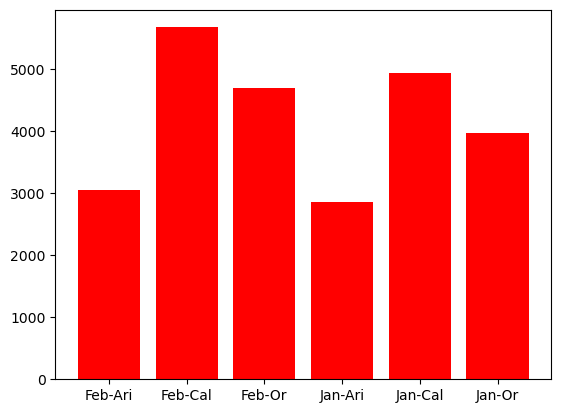

In [185]:
import pandas as pd
import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv'

df = pd.read_csv(url)

#work on column
df.columns = [column.lower().replace(' ','_') for column in df.columns]
df = df.drop(columns=['unnamed:_0'])

#work on val
df['response'] = df['response'].fillna('No')


#5.

#split toute les valeurs par '/'
def conv(val):
    new_col =[]
    new_val = val.split('/')
    new_col.extend(new_val)
    return new_col
df['effective_to_date']= df['effective_to_date'].apply(conv)

#remplacer toute les valeurs spliter par mois
def month(val):
    if val[0]=='2':
        return '1'
    elif val[0]=='1':
        return '2'
df['effective_to_date']= df['effective_to_date'].apply(month)

#agg_df = df.groupby(['state','effective_to_date'],as_index=False)['number_of_policies'].sum()

#df_pivot = agg_df.pivot(index='state', columns='effective_to_date', values='number_of_policies')


#6.  Display a new DataFrame that contains the number of policies sold by month, by state, for the top 3 states with the highest number of policies sold.


#state_policies = df.groupby(['effective_to_date', 'state'])['number_of_policies'].sum()
#print(state_policies)

#valeur_integré = state_policies[state_policies > 2000].index
#df = df[df.set_index(['effective_to_date', 'state']).index.isin(valeur_integré)]
#state_policiess = df.groupby(['effective_to_date', 'state'])['number_of_policies'].sum()

#print(state_policiess)

t3s = df.groupby(['state'])['number_of_policies'].sum().nlargest(3)

states = []
for state, val in t3s.items():
    states.append(state)
df = df[df['state'].isin(states)]

df = df[["effective_to_date", "state", "number_of_policies"]]

df = df.reset_index()

df["effective_to_date"] = df["effective_to_date"].replace({
    "2" : "Feb",
    "1" : "Jan"})

df["state"] = df["state"].replace({
    "Arizona" : "Ari",
    "California" : "Cal",
    "Oregon" : "Or"})

df = df.rename(columns= {"effective_to_date":"month"})

result = df.groupby(["month", "state"])["number_of_policies"].sum()
result = result.reset_index()
print(result)

plt.bar(result["month"] + "-" + result["state"], result["number_of_policies"], color="red")
plt.show()

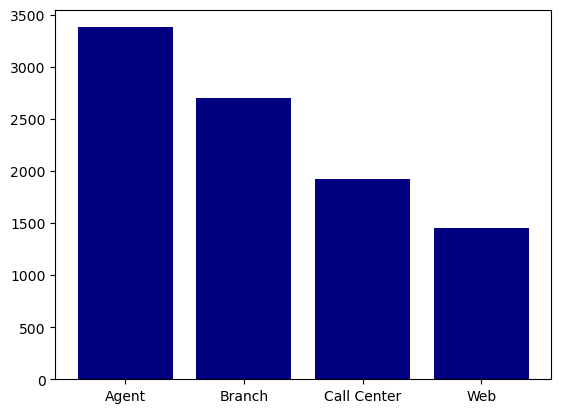

In [229]:
#The marketing team wants to analyze the effect of different marketing channels on the customer response rate.
#use melt to unpivot the data and create a table that shows the customer response rate (those who responded "Yes") by marketing channel

import pandas as pd
import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/data-bootcamp-v4/data/main/marketing_customer_analysis.csv'

df = pd.read_csv(url)

#work on column
df.columns = [column.lower().replace(' ','_') for column in df.columns]
df = df.drop(columns=['unnamed:_0'])

#work on val
df['response'] = df['response'].fillna('No')


#5.

#split toute les valeurs par '/'
def conv(val):
    new_col =[]
    new_val = val.split('/')
    new_col.extend(new_val)
    return new_col
df['effective_to_date']= df['effective_to_date'].apply(conv)

#remplacer toute les valeurs spliter par mois
def month(val):
    if val[0]=='2':
        return '1'
    elif val[0]=='1':
        return '2'
df['effective_to_date']= df['effective_to_date'].apply(month)


df["effective_to_date"] = df["effective_to_date"].replace({
    "2" : "Feb",
    "1" : "Jan"})


market = df.groupby(["sales_channel", "response"])["response"].count().reset_index(name="response_count")
market = market.reset_index()

plt.bar(market["sales_channel"], market["response_count"], color="navy")
plt.show()